In [123]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random_deletion
import data_recovery

from importlib import reload
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score

In [270]:
reload(data_recovery)

<module 'data_recovery' from '/Users/emilkaumov/Documents/cmc/special/missing_value/data_recovery.py'>

### Загрузим  и подготовим данные

In [95]:
creditg = pd.read_csv("dataset/credit-g.csv", header=1)
krkp    = pd.read_csv("dataset/kr-vs-kp.csv", header=1)
segment = pd.read_csv("dataset/segment.csv",  header=1)

1. Сделаем маску для разделения категориальных/порядковых признаков от количественных признаков.
2. Заменим все категориальные на числовые.
3. Выделим целевой вектор.

#### KRKP

In [96]:
krkp.columns = ["col" + str(i) for i in range(1, krkp.shape[1] + 1)]

In [97]:
krkp_mask = np.ones(krkp.shape[0], dtype=bool)

In [98]:
for i in range(1, krkp.shape[1] + 1):
    if krkp_mask[i - 1]:
        krkp["col" + str(i)] = LabelEncoder().fit_transform(krkp["col" + str(i)])

In [99]:
krkp_y    = krkp["col37"]
krkp_mask = krkp_mask[:-1]
krkp.drop("col37", axis=1, inplace=True)

In [100]:
krkp   = np.array(krkp, dtype='float')
krkp_y = np.array(krkp_y)

In [101]:
krkp

array([[ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.]])

#### Credit-g

In [102]:
creditg.columns = ["col" + str(i) for i in range(1, creditg.shape[1] + 1)]

In [103]:
creditg_mask     = np.ones(creditg.shape[1], dtype=bool)
creditg_mask[1]  = False
creditg_mask[4]  = False
creditg_mask[12] = False

In [104]:
for i in range(1, creditg.shape[1] + 1):
    if creditg_mask[i - 1]: 
        creditg["col" + str(i)] = LabelEncoder().fit_transform(creditg["col" + str(i)])

In [105]:
creditg_y    = creditg['col21']
creditg_mask = creditg_mask[:-1]
creditg.drop("col21", axis=1, inplace=True)

In [106]:
creditg   = np.array(creditg, dtype='float')
creditg_y = np.array(creditg_y)

In [107]:
creditg

array([[  1.,   6.,   1., ...,   0.,   1.,   1.],
       [  0.,  48.,   3., ...,   0.,   0.,   1.],
       [  3.,  12.,   1., ...,   1.,   0.,   1.],
       ..., 
       [  3.,  12.,   3., ...,   0.,   0.,   1.],
       [  1.,  45.,   3., ...,   0.,   1.,   1.],
       [  0.,  45.,   1., ...,   0.,   0.,   1.]])

#### Segment

In [108]:
segment.columns = ["col" + str(i) for i in range(1, segment.shape[1] + 1)]

In [109]:
segment_mask     = np.zeros(segment.shape[0], dtype=bool)
segment_mask[19] = True

In [110]:
for i in range(1, segment.shape[1] + 1):
    if segment_mask[i - 1]:
        segment["col" + str(i)] = LabelEncoder().fit_transform(segment["col" + str(i)])

In [111]:
segment_y    = segment['col20']
segment_mask = segment_mask[:-1]
segment.drop("col20", axis=1, inplace=True)

In [112]:
segment   = np.array(segment, dtype='float')
segment_y = np.array(segment_y)

### Сравнение методов.

##### 5 % пропущенных значений во всех объектах и всех признаках.

In [121]:
krkp_del    = random_deletion.make_missing_value(krkp,    del_fraction=0.05)
creditg_del = random_deletion.make_missing_value(creditg, del_fraction=0.05)
segment_del = random_deletion.make_missing_value(segment, del_fraction=0.05)

In [122]:
krkp_del

array([[  0.,   0.,   0., ...,   1.,  nan,   0.],
       [  0.,   0.,   0., ...,   1.,   1.,   0.],
       [  0.,   0.,   0., ...,   1.,   1.,   0.],
       ..., 
       [  1.,  nan,   0., ...,   1.,   0.,   0.],
       [  1.,   0.,   1., ...,   0.,   0.,   0.],
       [  1.,   0.,   1., ...,   0.,   0.,   0.]])

In [124]:
krkp_cv    = KFold(krkp_y.shape[0],    n_folds=10, shuffle=True, random_state=798)
creditg_cv = KFold(creditg_y.shape[0], n_folds=10, shuffle=True, random_state=798)
segment_cv = KFold(segment_y.shape[0], n_folds=10, shuffle=True, random_state=798)

clf = RandomForestClassifier(n_jobs=-1, random_state=567)

##### 1. Без пропущенных значений.

In [158]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp,    krkp_y,    scoring='accuracy', cv=krkp_cv)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg, creditg_y, scoring='accuracy', cv=creditg_cv)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment, segment_y, scoring='accuracy', cv=segment_cv)))

krkp:    0.98967
creditg: 0.73700
segment: 0.97619


##### 2. Игнорируем объекты с пропущенными значениями.

In [151]:
krkp_del_ignore,    krkp_y_ignore    = data_recovery.ignore_imputer(krkp_del,    krkp_y)
creditg_del_ignore, creditg_y_ignore = data_recovery.ignore_imputer(creditg_del, creditg_y)
segment_del_ignore, segment_y_ignore = data_recovery.ignore_imputer(segment_del, segment_y)

In [152]:
print('krkp:   ', krkp_del.shape, '->', krkp_del_ignore.shape)
print('creditg:', creditg_del.shape, '->', creditg_del_ignore.shape)
print('segment:', segment_del.shape, '->', segment_del_ignore.shape)

krkp:    (3196, 36) -> (523, 36)
creditg: (1000, 20) -> (347, 20)
segment: (2310, 19) -> (861, 19)


In [159]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp_del_ignore,    krkp_y_ignore,    scoring='accuracy', cv=10)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg_del_ignore, creditg_y_ignore, scoring='accuracy', cv=10)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment_del_ignore, segment_y_ignore, scoring='accuracy', cv=10)))

krkp:    0.87534
creditg: 0.70893
segment: 0.95956


##### 3. Заполнение специальным значение (-1).

In [154]:
krkp_del_special    = data_recovery.special_value_imputer(krkp_del, -1)
creditg_del_special = data_recovery.special_value_imputer(creditg_del, -1)
segment_del_special = data_recovery.special_value_imputer(segment_del, -1)

In [160]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp_del_special,    krkp_y,    scoring='accuracy', cv=krkp_cv)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg_del_special, creditg_y, scoring='accuracy', cv=creditg_cv)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment_del_special, segment_y, scoring='accuracy', cv=segment_cv)))

krkp:    0.95618
creditg: 0.69500
segment: 0.96407


##### 4. Заполнение самым частым/средним значением.

In [163]:
krkp_del_common    = data_recovery.common_value_imputer(krkp_del,    krkp_mask)
creditg_del_common = data_recovery.common_value_imputer(creditg_del, creditg_mask)
segment_del_common = data_recovery.common_value_imputer(segment_del, segment_mask)

In [169]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp_del_common,    krkp_y,    scoring='accuracy', cv=krkp_cv)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg_del_common, creditg_y, scoring='accuracy', cv=creditg_cv)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment_del_common, segment_y, scoring='accuracy', cv=segment_cv)))

krkp:    0.95431
creditg: 0.71700
segment: 0.96061


##### 5. Заполнение с помощью SVD.

С десятью итерациями:

In [222]:
krkp_del_svd    = data_recovery.svd_imputer(krkp_del,    krkp_mask,    rank=23, max_iter=10)
creditg_del_svd = data_recovery.svd_imputer(creditg_del, creditg_mask, rank=10, max_iter=10)
segment_del_svd = data_recovery.svd_imputer(segment_del, segment_mask, rank=4,  max_iter=10)

In [223]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp_del_svd,    krkp_y,    scoring='accuracy', cv=krkp_cv)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg_del_svd, creditg_y, scoring='accuracy', cv=creditg_cv)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment_del_svd, segment_y, scoring='accuracy', cv=segment_cv)))

krkp:    0.94805
creditg: 0.73600
segment: 0.96623


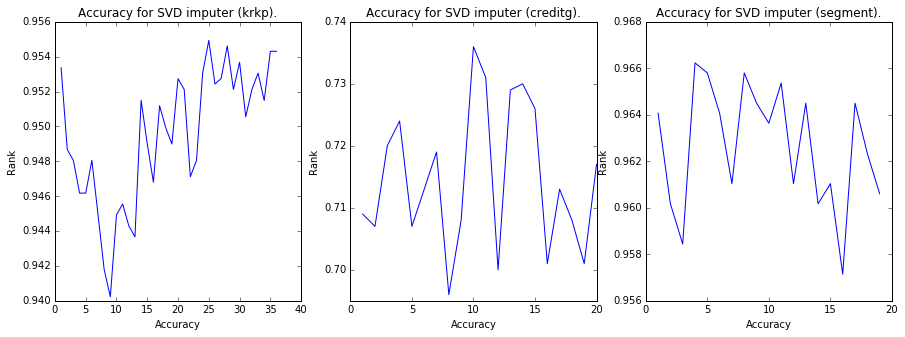

In [221]:
krkp_accuracy    = []
creditg_accuracy = []
segment_accuracy = []

for i in range(1, krkp.shape[1] + 1):
    krkp_del_svd = data_recovery.svd_imputer(krkp_del, krkp_mask, rank=i, max_iter=10)
    krkp_accuracy.append(np.mean(cross_val_score(clf, krkp_del_svd, krkp_y, scoring='accuracy', cv=krkp_cv)))
    
for i in range(1, creditg.shape[1] + 1):
    creditg_del_svd = data_recovery.svd_imputer(creditg_del, creditg_mask, rank=i, max_iter=10)
    creditg_accuracy.append(np.mean(cross_val_score(clf, creditg_del_svd, creditg_y, scoring='accuracy', cv=creditg_cv)))

for i in range(1, segment.shape[1] + 1):
    segment_del_svd = data_recovery.svd_imputer(segment_del, segment_mask, rank=i, max_iter=10)
    segment_accuracy.append(np.mean(cross_val_score(clf, segment_del_svd, segment_y, scoring='accuracy', cv=segment_cv)))
    
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 3, 1)
plt.plot(list(range(1, krkp.shape[1] + 1)), krkp_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer (krkp).")

plt.subplot(1, 3, 2)
plt.plot(list(range(1, creditg.shape[1] + 1)), creditg_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer (creditg).")

plt.subplot(1, 3, 3)
plt.plot(list(range(1, segment.shape[1] + 1)), segment_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer (segment).")

plt.show()

С одной итерацией:

In [219]:
krkp_del_svd    = data_recovery.svd_imputer(krkp_del,    krkp_mask,    rank=17, max_iter=1)
creditg_del_svd = data_recovery.svd_imputer(creditg_del, creditg_mask, rank=13, max_iter=1)
segment_del_svd = data_recovery.svd_imputer(segment_del, segment_mask, rank=7, max_iter=1)

In [220]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp_del_svd,    krkp_y,    scoring='accuracy', cv=krkp_cv)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg_del_svd, creditg_y, scoring='accuracy', cv=creditg_cv)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment_del_svd, segment_y, scoring='accuracy', cv=segment_cv)))

krkp:    0.95525
creditg: 0.73400
segment: 0.96580


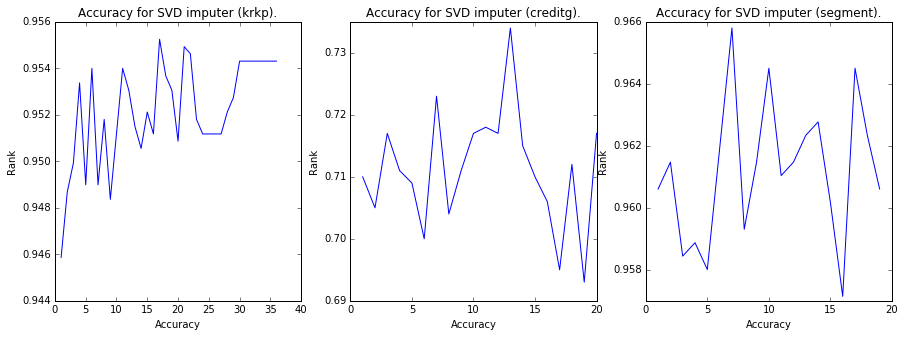

In [218]:
krkp_accuracy    = []
creditg_accuracy = []
segment_accuracy = []

for i in range(1, krkp.shape[1] + 1):
    krkp_del_svd = data_recovery.svd_imputer(krkp_del, krkp_mask, rank=i, max_iter=1)
    krkp_accuracy.append(np.mean(cross_val_score(clf, krkp_del_svd, krkp_y, scoring='accuracy', cv=krkp_cv)))
    
for i in range(1, creditg.shape[1] + 1):
    creditg_del_svd = data_recovery.svd_imputer(creditg_del, creditg_mask, rank=i, max_iter=1)
    creditg_accuracy.append(np.mean(cross_val_score(clf, creditg_del_svd, creditg_y, scoring='accuracy', cv=creditg_cv)))

for i in range(1, segment.shape[1] + 1):
    segment_del_svd = data_recovery.svd_imputer(segment_del, segment_mask, rank=i, max_iter=1)
    segment_accuracy.append(np.mean(cross_val_score(clf, segment_del_svd, segment_y, scoring='accuracy', cv=segment_cv)))
    
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 3, 1)
plt.plot(list(range(1, krkp.shape[1] + 1)), krkp_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer (krkp).")

plt.subplot(1, 3, 2)
plt.plot(list(range(1, creditg.shape[1] + 1)), creditg_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer (creditg).")

plt.subplot(1, 3, 3)
plt.plot(list(range(1, segment.shape[1] + 1)), segment_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer (segment).")

plt.show()

##### 6. Заполнение с помощью kNN.

In [235]:
krkp_del_knn    = data_recovery.knn_imputer(krkp_del,    krkp_mask,    n_neighbors=8)
creditg_del_knn = data_recovery.knn_imputer(creditg_del, creditg_mask, n_neighbors=1)
segment_del_knn = data_recovery.knn_imputer(segment_del, segment_mask, n_neighbors=4)

In [236]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp_del_knn,    krkp_y,    scoring='accuracy', cv=krkp_cv)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg_del_knn, creditg_y, scoring='accuracy', cv=creditg_cv)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment_del_knn, segment_y, scoring='accuracy', cv=segment_cv)))

krkp:    0.95618
creditg: 0.72600
segment: 0.96926


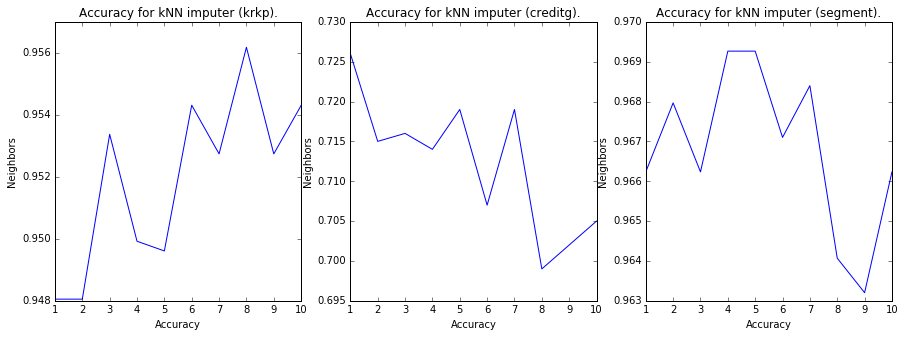

In [234]:
krkp_accuracy    = []
creditg_accuracy = []
segment_accuracy = []

for i in range(1, 11):
    krkp_del_knn = data_recovery.knn_imputer(krkp_del, krkp_mask, n_neighbors=i)
    krkp_accuracy.append(np.mean(cross_val_score(clf, krkp_del_knn, krkp_y, scoring='accuracy', cv=krkp_cv)))
    
for i in range(1, 11):
    creditg_del_knn = data_recovery.knn_imputer(creditg_del, creditg_mask, n_neighbors=i)
    creditg_accuracy.append(np.mean(cross_val_score(clf, creditg_del_knn, creditg_y, scoring='accuracy', cv=creditg_cv)))

for i in range(1, 11):
    segment_del_knn = data_recovery.knn_imputer(segment_del, segment_mask, n_neighbors=i)
    segment_accuracy.append(np.mean(cross_val_score(clf, segment_del_knn, segment_y, scoring='accuracy', cv=segment_cv)))
    
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 3, 1)
plt.plot(list(range(1, 11)), krkp_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Neighbors")
plt.title("Accuracy for kNN imputer (krkp).")

plt.subplot(1, 3, 2)
plt.plot(list(range(1, 11)), creditg_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Neighbors")
plt.title("Accuracy for kNN imputer (creditg).")

plt.subplot(1, 3, 3)
plt.plot(list(range(1, 11)), segment_accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Neighbors")
plt.title("Accuracy for kNN imputer (segment).")

plt.show()

##### 7. Заполнение с помощью Random Forest.

In [239]:
krkp_del_rf    = data_recovery.rf_imputer(krkp_del,    krkp_mask)
creditg_del_rf = data_recovery.rf_imputer(creditg_del, creditg_mask)
segment_del_rf = data_recovery.rf_imputer(segment_del, segment_mask)

In [240]:
print('krkp:   ', '%.5f' % np.mean(cross_val_score(clf, krkp_del_rf,    krkp_y,    scoring='accuracy', cv=krkp_cv)))
print('creditg:', '%.5f' % np.mean(cross_val_score(clf, creditg_del_rf, creditg_y, scoring='accuracy', cv=creditg_cv)))
print('segment:', '%.5f' % np.mean(cross_val_score(clf, segment_del_rf, segment_y, scoring='accuracy', cv=segment_cv)))

krkp:    0.94367
creditg: 0.71900
segment: 0.97056


### Сравним для разных долей пропущенных значений.

Пропущенные значения для всех объектов в _половине_ признаков. 

In [271]:
missing_frac_range = [0.05, 0.1, 0.15, 0.2, 0.25]
num_iter = 3

In [272]:
krkp_accuracy_special = []
krkp_accuracy_common  = []
krkp_accuracy_svd     = []
krkp_accuracy_knn     = []
krkp_accuracy_rf      = []

krkp_rmse_special = []
krkp_rmse_common  = []
krkp_rmse_svd     = []
krkp_rmse_knn     = []
krkp_rmse_rf      = []

creditg_accuracy_special = []
creditg_accuracy_common  = []
creditg_accuracy_svd     = []
creditg_accuracy_knn     = []
creditg_accuracy_rf      = []

creditg_rmse_special = []
creditg_rmse_common  = []
creditg_rmse_svd     = []
creditg_rmse_knn     = []
creditg_rmse_rf      = []

segment_accuracy_special = []
segment_accuracy_common  = []
segment_accuracy_svd     = []
segment_accuracy_knn     = []
segment_accuracy_rf      = []

segment_rmse_special = []
segment_rmse_common  = []
segment_rmse_svd     = []
segment_rmse_knn     = []
segment_rmse_rf      = []

In [273]:
for missing_frac in missing_frac_range:
    for iteration in range(num_iter):
        krkp_del    = random_deletion.make_missing_value(krkp,    del_fraction=missing_frac, del_fraction_column=0.5)
        creditg_del = random_deletion.make_missing_value(creditg, del_fraction=missing_frac, del_fraction_column=0.5)
        segment_del = random_deletion.make_missing_value(segment, del_fraction=missing_frac, del_fraction_column=0.5)
        
        # special value
        krkp_tmp    = data_recovery.special_value_imputer(krkp_del)
        creditg_tmp = data_recovery.special_value_imputer(creditg_del)
        segment_tmp = data_recovery.special_value_imputer(segment_del)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_special.append(accuracy_krkp / num_iter)
            creditg_accuracy_special.append(accuracy_creditg / num_iter)
            segment_accuracy_special.append(accuracy_segment / num_iter)
            krkp_rmse_special.append(rmse_krkp / num_iter)
            creditg_rmse_special.append(rmse_creditg / num_iter)
            segment_rmse_special.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_special[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_special[-1] += accuracy_creditg / num_iter
            segment_accuracy_special[-1] += accuracy_segment / num_iter
            krkp_rmse_special[-1]    += rmse_krkp    / num_iter
            creditg_rmse_special[-1] += rmse_creditg / num_iter
            segment_rmse_special[-1] += rmse_segment / num_iter
            
        # common value
        krkp_tmp    = data_recovery.common_value_imputer(krkp_del,    krkp_mask)
        creditg_tmp = data_recovery.common_value_imputer(creditg_del, creditg_mask)
        segment_tmp = data_recovery.common_value_imputer(segment_del, segment_mask)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_common.append(accuracy_krkp / num_iter)
            creditg_accuracy_common.append(accuracy_creditg / num_iter)
            segment_accuracy_common.append(accuracy_segment / num_iter)
            krkp_rmse_common.append(rmse_krkp / num_iter)
            creditg_rmse_common.append(rmse_creditg / num_iter)
            segment_rmse_common.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_common[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_common[-1] += accuracy_creditg / num_iter
            segment_accuracy_common[-1] += accuracy_segment / num_iter
            krkp_rmse_common[-1]    += rmse_krkp    / num_iter
            creditg_rmse_common[-1] += rmse_creditg / num_iter
            segment_rmse_common[-1] += rmse_segment / num_iter
            
        # svd
        krkp_tmp    = data_recovery.svd_imputer(krkp_del,    krkp_mask,    rank=20)
        creditg_tmp = data_recovery.svd_imputer(creditg_del, creditg_mask, rank=20)
        segment_tmp = data_recovery.svd_imputer(segment_del, segment_mask, rank=20)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_svd.append(accuracy_krkp / num_iter)
            creditg_accuracy_svd.append(accuracy_creditg / num_iter)
            segment_accuracy_svd.append(accuracy_segment / num_iter)
            krkp_rmse_svd.append(rmse_krkp / num_iter)
            creditg_rmse_svd.append(rmse_creditg / num_iter)
            segment_rmse_svd.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_svd[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_svd[-1] += accuracy_creditg / num_iter
            segment_accuracy_svd[-1] += accuracy_segment / num_iter
            krkp_rmse_svd[-1]    += rmse_krkp    / num_iter
            creditg_rmse_svd[-1] += rmse_creditg / num_iter
            segment_rmse_svd[-1] += rmse_segment / num_iter
            
        # knn
        krkp_tmp    = data_recovery.knn_imputer(krkp_del,    krkp_mask,    n_neighbors=5)
        creditg_tmp = data_recovery.knn_imputer(creditg_del, creditg_mask, n_neighbors=5)
        segment_tmp = data_recovery.knn_imputer(segment_del, segment_mask, n_neighbors=5)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_knn.append(accuracy_krkp / num_iter)
            creditg_accuracy_knn.append(accuracy_creditg / num_iter)
            segment_accuracy_knn.append(accuracy_segment / num_iter)
            krkp_rmse_knn.append(rmse_krkp / num_iter)
            creditg_rmse_knn.append(rmse_creditg / num_iter)
            segment_rmse_knn.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_knn[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_knn[-1] += accuracy_creditg / num_iter
            segment_accuracy_knn[-1] += accuracy_segment / num_iter
            krkp_rmse_knn[-1]    += rmse_krkp    / num_iter
            creditg_rmse_knn[-1] += rmse_creditg / num_iter
            segment_rmse_knn[-1] += rmse_segment / num_iter
            
        # rf
        krkp_tmp    = data_recovery.rf_imputer(krkp_del,    krkp_mask)
        creditg_tmp = data_recovery.rf_imputer(creditg_del, creditg_mask)
        segment_tmp = data_recovery.rf_imputer(segment_del, segment_mask)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_rf.append(accuracy_krkp / num_iter)
            creditg_accuracy_rf.append(accuracy_creditg / num_iter)
            segment_accuracy_rf.append(accuracy_segment / num_iter)
            krkp_rmse_rf.append(rmse_krkp / num_iter)
            creditg_rmse_rf.append(rmse_creditg / num_iter)
            segment_rmse_rf.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_rf[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_rf[-1] += accuracy_creditg / num_iter
            segment_accuracy_rf[-1] += accuracy_segment / num_iter
            krkp_rmse_rf[-1]    += rmse_krkp    / num_iter
            creditg_rmse_rf[-1] += rmse_creditg / num_iter
            segment_rmse_rf[-1] += rmse_segment / num_iter

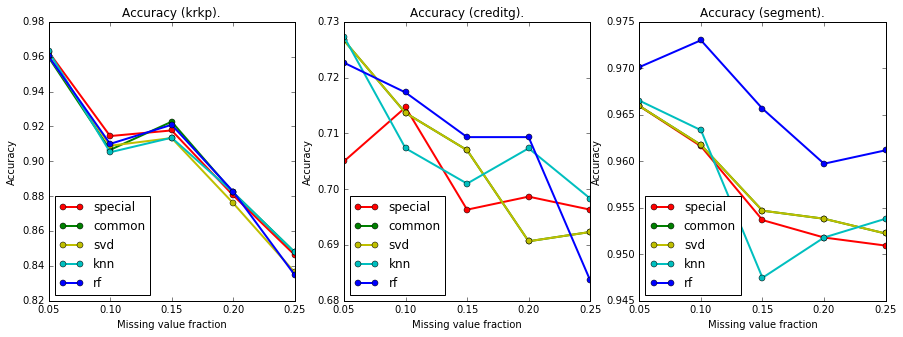

In [274]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Accuracy (krkp).")
plt.plot(missing_frac_range, krkp_accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 2)
plt.title("Accuracy (creditg).")
plt.plot(missing_frac_range, creditg_accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.title("Accuracy (segment).")
plt.plot(missing_frac_range, segment_accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, segment_accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, segment_accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, segment_accuracy_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, segment_accuracy_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

plt.show()

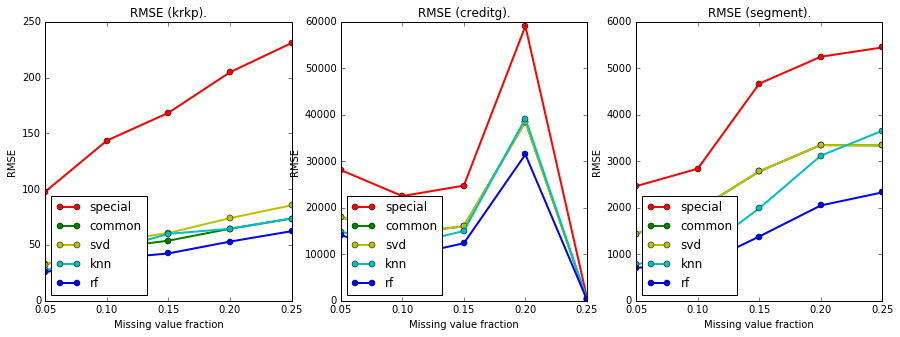

In [275]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("RMSE (krkp).")
plt.plot(missing_frac_range, krkp_rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, krkp_rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, krkp_rmse_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, krkp_rmse_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, krkp_rmse_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")

plt.subplot(1, 3, 2)
plt.title("RMSE (creditg).")
plt.plot(missing_frac_range, creditg_rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, creditg_rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, creditg_rmse_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, creditg_rmse_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, creditg_rmse_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")

plt.subplot(1, 3, 3)
plt.title("RMSE (segment).")
plt.plot(missing_frac_range, segment_rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, segment_rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, segment_rmse_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, segment_rmse_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, segment_rmse_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")

plt.show()

Пропущенные значения для всех объектов во _всех_ признаках. 

In [276]:
krkp_accuracy_special = []
krkp_accuracy_common  = []
krkp_accuracy_svd     = []
krkp_accuracy_knn     = []
krkp_accuracy_rf      = []

krkp_rmse_special = []
krkp_rmse_common  = []
krkp_rmse_svd     = []
krkp_rmse_knn     = []
krkp_rmse_rf      = []

creditg_accuracy_special = []
creditg_accuracy_common  = []
creditg_accuracy_svd     = []
creditg_accuracy_knn     = []
creditg_accuracy_rf      = []

creditg_rmse_special = []
creditg_rmse_common  = []
creditg_rmse_svd     = []
creditg_rmse_knn     = []
creditg_rmse_rf      = []

segment_accuracy_special = []
segment_accuracy_common  = []
segment_accuracy_svd     = []
segment_accuracy_knn     = []
segment_accuracy_rf      = []

segment_rmse_special = []
segment_rmse_common  = []
segment_rmse_svd     = []
segment_rmse_knn     = []
segment_rmse_rf      = []

In [277]:
for missing_frac in missing_frac_range:
    for iteration in range(num_iter):
        krkp_del    = random_deletion.make_missing_value(krkp,    del_fraction=missing_frac, del_fraction_column=1.0)
        creditg_del = random_deletion.make_missing_value(creditg, del_fraction=missing_frac, del_fraction_column=1.0)
        segment_del = random_deletion.make_missing_value(segment, del_fraction=missing_frac, del_fraction_column=1.0)
        
        # special value
        krkp_tmp    = data_recovery.special_value_imputer(krkp_del)
        creditg_tmp = data_recovery.special_value_imputer(creditg_del)
        segment_tmp = data_recovery.special_value_imputer(segment_del)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_special.append(accuracy_krkp / num_iter)
            creditg_accuracy_special.append(accuracy_creditg / num_iter)
            segment_accuracy_special.append(accuracy_segment / num_iter)
            krkp_rmse_special.append(rmse_krkp / num_iter)
            creditg_rmse_special.append(rmse_creditg / num_iter)
            segment_rmse_special.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_special[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_special[-1] += accuracy_creditg / num_iter
            segment_accuracy_special[-1] += accuracy_segment / num_iter
            krkp_rmse_special[-1]    += rmse_krkp    / num_iter
            creditg_rmse_special[-1] += rmse_creditg / num_iter
            segment_rmse_special[-1] += rmse_segment / num_iter
            
        # common value
        krkp_tmp    = data_recovery.common_value_imputer(krkp_del,    krkp_mask)
        creditg_tmp = data_recovery.common_value_imputer(creditg_del, creditg_mask)
        segment_tmp = data_recovery.common_value_imputer(segment_del, segment_mask)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_common.append(accuracy_krkp / num_iter)
            creditg_accuracy_common.append(accuracy_creditg / num_iter)
            segment_accuracy_common.append(accuracy_segment / num_iter)
            krkp_rmse_common.append(rmse_krkp / num_iter)
            creditg_rmse_common.append(rmse_creditg / num_iter)
            segment_rmse_common.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_common[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_common[-1] += accuracy_creditg / num_iter
            segment_accuracy_common[-1] += accuracy_segment / num_iter
            krkp_rmse_common[-1]    += rmse_krkp    / num_iter
            creditg_rmse_common[-1] += rmse_creditg / num_iter
            segment_rmse_common[-1] += rmse_segment / num_iter
            
        # svd
        krkp_tmp    = data_recovery.svd_imputer(krkp_del,    krkp_mask,    rank=20)
        creditg_tmp = data_recovery.svd_imputer(creditg_del, creditg_mask, rank=20)
        segment_tmp = data_recovery.svd_imputer(segment_del, segment_mask, rank=20)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_svd.append(accuracy_krkp / num_iter)
            creditg_accuracy_svd.append(accuracy_creditg / num_iter)
            segment_accuracy_svd.append(accuracy_segment / num_iter)
            krkp_rmse_svd.append(rmse_krkp / num_iter)
            creditg_rmse_svd.append(rmse_creditg / num_iter)
            segment_rmse_svd.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_svd[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_svd[-1] += accuracy_creditg / num_iter
            segment_accuracy_svd[-1] += accuracy_segment / num_iter
            krkp_rmse_svd[-1]    += rmse_krkp    / num_iter
            creditg_rmse_svd[-1] += rmse_creditg / num_iter
            segment_rmse_svd[-1] += rmse_segment / num_iter
            
        # knn
        krkp_tmp    = data_recovery.knn_imputer(krkp_del,    krkp_mask,    n_neighbors=5)
        creditg_tmp = data_recovery.knn_imputer(creditg_del, creditg_mask, n_neighbors=5)
        segment_tmp = data_recovery.knn_imputer(segment_del, segment_mask, n_neighbors=5)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_knn.append(accuracy_krkp / num_iter)
            creditg_accuracy_knn.append(accuracy_creditg / num_iter)
            segment_accuracy_knn.append(accuracy_segment / num_iter)
            krkp_rmse_knn.append(rmse_krkp / num_iter)
            creditg_rmse_knn.append(rmse_creditg / num_iter)
            segment_rmse_knn.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_knn[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_knn[-1] += accuracy_creditg / num_iter
            segment_accuracy_knn[-1] += accuracy_segment / num_iter
            krkp_rmse_knn[-1]    += rmse_krkp    / num_iter
            creditg_rmse_knn[-1] += rmse_creditg / num_iter
            segment_rmse_knn[-1] += rmse_segment / num_iter
            
        # rf
        krkp_tmp    = data_recovery.rf_imputer(krkp_del,    krkp_mask)
        creditg_tmp = data_recovery.rf_imputer(creditg_del, creditg_mask)
        segment_tmp = data_recovery.rf_imputer(segment_del, segment_mask)
        accuracy_krkp    = np.mean(cross_val_score(clf, krkp_tmp,    krkp_y,    scoring='accuracy', cv=krkp_cv))
        accuracy_creditg = np.mean(cross_val_score(clf, creditg_tmp, creditg_y, scoring='accuracy', cv=creditg_cv))
        accuracy_segment = np.mean(cross_val_score(clf, segment_tmp, segment_y, scoring='accuracy', cv=segment_cv))
        rmse_krkp    = np.sum((krkp    - krkp_tmp)    ** 2) ** 0.5
        rmse_creditg = np.sum((creditg - creditg_tmp) ** 2) ** 0.5
        rmse_segment = np.sum((segment - segment_tmp) ** 2) ** 0.5
        if iteration == 0:
            krkp_accuracy_rf.append(accuracy_krkp / num_iter)
            creditg_accuracy_rf.append(accuracy_creditg / num_iter)
            segment_accuracy_rf.append(accuracy_segment / num_iter)
            krkp_rmse_rf.append(rmse_krkp / num_iter)
            creditg_rmse_rf.append(rmse_creditg / num_iter)
            segment_rmse_rf.append(rmse_segment / num_iter)
        else:
            krkp_accuracy_rf[-1]    += accuracy_krkp    / num_iter
            creditg_accuracy_rf[-1] += accuracy_creditg / num_iter
            segment_accuracy_rf[-1] += accuracy_segment / num_iter
            krkp_rmse_rf[-1]    += rmse_krkp    / num_iter
            creditg_rmse_rf[-1] += rmse_creditg / num_iter
            segment_rmse_rf[-1] += rmse_segment / num_iter

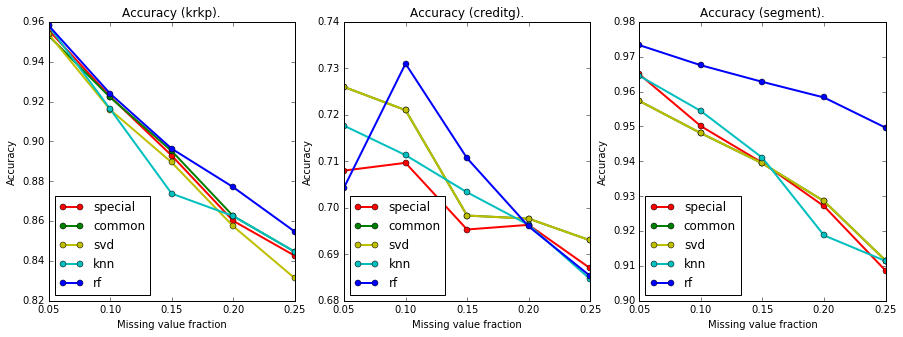

In [278]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Accuracy (krkp).")
plt.plot(missing_frac_range, krkp_accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, krkp_accuracy_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 2)
plt.title("Accuracy (creditg).")
plt.plot(missing_frac_range, creditg_accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, creditg_accuracy_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 3)
plt.title("Accuracy (segment).")
plt.plot(missing_frac_range, segment_accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, segment_accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, segment_accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, segment_accuracy_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, segment_accuracy_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

plt.show()

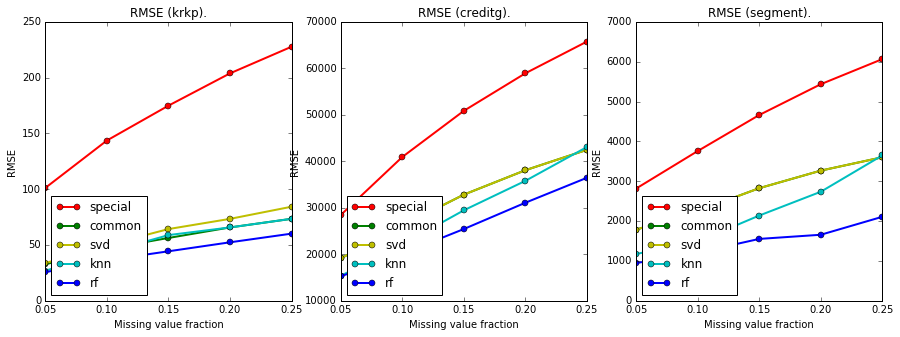

In [279]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("RMSE (krkp).")
plt.plot(missing_frac_range, krkp_rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, krkp_rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, krkp_rmse_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, krkp_rmse_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, krkp_rmse_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")

plt.subplot(1, 3, 2)
plt.title("RMSE (creditg).")
plt.plot(missing_frac_range, creditg_rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, creditg_rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, creditg_rmse_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, creditg_rmse_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, creditg_rmse_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")

plt.subplot(1, 3, 3)
plt.title("RMSE (segment).")
plt.plot(missing_frac_range, segment_rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, segment_rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, segment_rmse_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, segment_rmse_knn, 'co-', label='knn', lw=2)
plt.plot(missing_frac_range, segment_rmse_rf, 'bo-', label='rf', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")

plt.show()